# <font color='blue'> Projet 7 : Implémentez un modèle de scoring </font>

# Table of contents
1. [Import libraries](#1)
2. [Data preparation and feature engineering](#2)
3. [Additional data cleaning](#3)
* 3.1. [Handling missing values](#3.1)
* 3.2. [Duplicates](#3.2)
* 3.3. [Basic statistical measures](#3.3)
4. [Preparation of datasets (2 versions)](#4)
* 4.1. [Dataset with missing values](#4.1)
* 4.2. [Dataset with no missing values](#4.2)
5. [Data exploration: TARGET variable](#5)
* 5.1 [Data distribution](#5.1)
* 5.2 [Correlations](#5.2)
6. [Modeling](#6)
* 6.1 [Models: Linear, Probabilistic, and Non-linear](#6.1)
* 6.2.1 [Logistic Regression](#6.2.1)
* 6.2.2 [Bayesian Classifier](#6.2.2)
* 6.2.3 [LGBM Classifier](#6.2.3)
* 6.2.4 [LGBM Classifier with null values](#6.2.4)
* 6.3 [Models: Comparison](#6.3)
* 6.4 [Custom score: Threshold optimisation](#6.4)
* 6.5 [Feature importance](#6.5)
* 6.5.1 [Global feature importance](#6.5.1)
* 6.5.2 [Local feature importance](#6.5.2)
7. [Data drift by Evidently](#7)


# <a id="1"></a>1. Import libraries

In [1]:
# Essential data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utility modules
import re
import os
import gc
import time
from contextlib import contextmanager

# Scikit-learn modules for data preprocessing and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
from mlflow.sklearn import log_model

# Scikit-learn pipeline for constructing a series of data processing steps
from sklearn.pipeline import Pipeline

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

# Importing SHAP for model interpretability
import shap

# Modules for saving and loading models
import joblib
import pickle

# Evidently for model performance monitoring
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Webbrowser for opening generated reports in a web browser
import webbrowser

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# <a id="2"></a>2. Data preparation and feature engineering

As suggested, I am using Kaggle kernel for data preparation and feature engeneering. 
The kernel used: https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [3]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        
    df.drop(columns='index', inplace=True)
    
    return df

In [4]:
df = main()

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 17s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 19s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 8s
Installments payments df shape: (339587, 26)
Process installments payments - done in 20s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 11s


In [5]:
df.shape

(356251, 797)

# <a id="3"></a>3. Additional data cleaning

## <a id="3.1"></a>3.1 Handling missing values

In [6]:
# Calculate the nr and the percentage of missing values
def calculate_missing(df, print_result=True, include_zero_missing=False):
    total_missing = df.isna().sum()
    total_rows = df.shape[0]
    total_columns = df.shape[1]
    total_missing_values = total_missing.sum()
    missing_cols = ['column', 'n_miss', '%_miss']
    
    missing_df = pd.DataFrame(columns=missing_cols)
    missing_df['column'] = total_missing.index
    missing_df['n_miss'] = total_missing.values
    missing_df['%_miss'] = round(missing_df['n_miss'] / total_rows * 100, 1)
    missing_df = missing_df[missing_df['n_miss'] > 0].sort_values('n_miss', ascending=False)
    
    if not include_zero_missing:
        missing_df = missing_df[missing_df['%_miss'] > 0]
    
    if print_result:
        total_missing_msg = f"Total missing values: {total_missing_values}"
        total_percentage_msg = f"Percentage of missing values in the dataset: {round(total_missing_values / (total_rows * total_columns) * 100, 2)}%"
        print(total_missing_msg)
        print(total_percentage_msg)
    
    return missing_df

In [7]:
missing_df = calculate_missing(df)
missing_df

Total missing values: 72099981
Percentage of missing values in the dataset: 25.39%


column  n_miss  %_miss
605   REFUSED_RATE_DOWN_PAYMENT_MAX  303648    85.2
604   REFUSED_RATE_DOWN_PAYMENT_MIN  303648    85.2
606  REFUSED_RATE_DOWN_PAYMENT_MEAN  303648    85.2
595    REFUSED_AMT_DOWN_PAYMENT_MIN  303648    85.2
596    REFUSED_AMT_DOWN_PAYMENT_MAX  303648    85.2
..                              ...     ...     ...
80         OBS_60_CNT_SOCIAL_CIRCLE    1050     0.3
79         DEF_30_CNT_SOCIAL_CIRCLE    1050     0.3
78         OBS_30_CNT_SOCIAL_CIRCLE    1050     0.3
33                     EXT_SOURCE_2     668     0.2
9                   AMT_GOODS_PRICE     278     0.1

[611 rows x 3 columns]

In [8]:
# Plot missing values percentage
def plot_missing(df, threshold, height=180):
    plt.figure(figsize=(10, height))
    sns.barplot(data=df.sort_values('%_miss', ascending=False), x='%_miss', y='column', color='grey')
    plt.title("Missing values (%) for each column")
    plt.xlabel("Missing values (%)")
    plt.ylabel("Column")
    plt.axvline(x=100 - threshold*100, linewidth=2, color='r')
    plt.show()

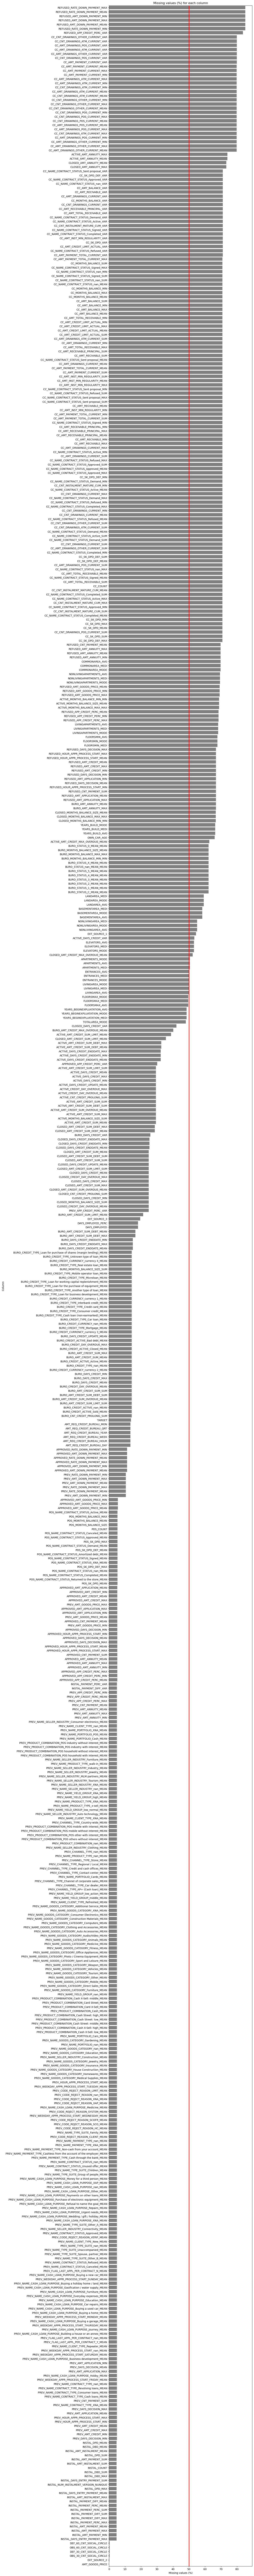

In [9]:
treshold = 0.5
plot_missing(missing_df, treshold)

Conclusion: I will get rid of collumns with more than 50% of data missing. This will lead to improved quality of the data and simplify the analysis. 

In [10]:
cols_to_drop = missing_df.loc[missing_df['%_miss'] > treshold * 100, 'column']
df = df.drop(columns=cols_to_drop)
df.shape

(356251, 564)

In [11]:
calculate_missing(df)

Total missing values: 14102762
Percentage of missing values in the dataset: 7.02%


column  n_miss  %_miss
35            LIVINGAREA_AVG  177901    49.9
41           LIVINGAREA_MEDI  177901    49.9
38           LIVINGAREA_MODE  177901    49.9
40            FLOORSMAX_MEDI  176340    49.5
34             FLOORSMAX_AVG  176340    49.5
..                       ...     ...     ...
46  DEF_60_CNT_SOCIAL_CIRCLE    1050     0.3
44  DEF_30_CNT_SOCIAL_CIRCLE    1050     0.3
45  OBS_60_CNT_SOCIAL_CIRCLE    1050     0.3
31              EXT_SOURCE_2     668     0.2
9            AMT_GOODS_PRICE     278     0.1

[378 rows x 3 columns]

## <a id="3.2"></a>3.2 Duplicates

In [12]:
n_duplicates = df.duplicated().sum()
print(f"In the dataset set there are {n_duplicates} duplicates.")

In the dataset set there are 0 duplicates.


## <a id="3.3"></a>3.3 Basic statistical measures

In [13]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [14]:
df.describe()

SK_ID_CURR    TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
count   356251.00 307507.00    356251.00     356251.00        356251.00   
mean    278128.87      0.08         0.66          0.34             0.31   
std     102842.07      0.27         0.47          0.47             0.46   
min     100001.00      0.00         0.00          0.00             0.00   
25%     189065.50      0.00         0.00          0.00             0.00   
50%     278129.00      0.00         1.00          0.00             0.00   
75%     367192.50      0.00         1.00          1.00             1.00   
max     456255.00      1.00         1.00          1.00             1.00   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
count     356251.00         356251.00   356251.00    356215.00   
mean           0.41         170115.87   587769.53     27425.64   
std            0.72         223508.02   398625.30     14732.86   
min            0.00          25650.00    45000.00      1615.50   
25%            0.00         112500.00   270000.00     16731.00   
50%            0.00         153000.00   500211.00     25078.50   
75%            1.00         202500.00   797557.50     34960.50   
max           20.00      117000000.00  4050000.00    258025.50   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
count        355973.00                   356251.00   356251.00      291603.00   
mean         528021.19                        0.02   -16041.28       -2396.68   
std          366065.67                        0.01     4358.80        2334.45   
min           40500.00                        0.00   -25229.00      -17912.00   
25%          234000.00                        0.01   -19676.00       -3200.00   
50%          450000.00                        0.02   -15755.00       -1663.00   
75%          675000.00                        0.03   -12425.00        -780.00   
max         4050000.00                        0.07    -7338.00           0.00   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
count          356251.00        356251.00   356251.00       356251.00   
mean            -4983.60         -3002.07        1.00            0.82   
std              3526.97          1517.91        0.00            0.39   
min            -24672.00         -7197.00        0.00            0.00   
25%             -7477.00         -4318.00        1.00            1.00   
50%             -4502.00         -3252.00        1.00            1.00   
75%             -1995.00         -1717.00        1.00            1.00   
max                 0.00             0.00        1.00            1.00   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
count        356251.00         356251.00   356251.00   356251.00   
mean              0.20              1.00        0.28        0.07   
std               0.40              0.04        0.45        0.26   
min               0.00              0.00        0.00        0.00   
25%               0.00              1.00        0.00        0.00   
50%               0.00              1.00        0.00        0.00   
75%               0.00              1.00        1.00        0.00   
max               1.00              1.00        1.00        1.00   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count        356249.00             356251.00                    356251.00   
mean              2.15                  2.05                         2.03   
std               0.91                  0.51                         0.50   
min               1.00                  1.00                        -1.00   
25%               2.00                  2.00                         2.00   
50%               2.00                  2.00                         2.00   
75%               3.00                  2.00                         2.00   
max              21.00                  3.00                         3.00   

       HOUR_APPR_PROCESS_START  REG_REGIO

In [15]:
count_rows_with_infinite = (df.isin([np.inf, -np.inf])).any(axis=1).sum()
count_rows_with_infinite

20

In [16]:
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]

In [17]:
df.shape

(356231, 564)

Conclusion: There are infinite values that should taken care of. Since there are only 20, I remove those rows from the dataframe. 

## <a id="4"></a>4. Preparation of datasets (2 versions)

The task involves experimenting with the modeling of various models. Some of these models are capable of handling missing values, while others are not. As a result, I am preparing two versions of datasets: one containing missing values and the other with all values present.

## <a id="4.1"></a>4.1 Dataset with missing values

In [18]:
df_V1 = df[df['TARGET'].notna()]
df_V1_T = df[df['TARGET'].isna()]

In [19]:
# Create regrex to clean feature names
def clean_feature_name(feature_name):
    cleaned_name = re.sub(r'[^a-zA-Z0-9_]', '_', feature_name)
    return cleaned_name

In [20]:
df_V1 = df_V1.rename(columns={col: clean_feature_name(col) for col in df_V1.columns})
df_V1_T = df_V1_T.rename(columns={col: clean_feature_name(col) for col in df_V1_T.columns})

In [21]:
df_V1.to_csv('df_V1.csv', index=False)
df_V1_T.to_csv('df_V1_T.csv', index=False)

## <a id="4.2"></a>4.2 Dataset with no missing values

Strategy: 
- Temporarily fill the TARGET varaible.
- Fill missing values in columns representing summary statistics with zeros, assuming no contribution. 
- For numerical variables, use median imputation, providing a straightforward and robust approach that effectively handles outliers while ensuring clarity and statistical reliability in data preprocessing.

In [22]:
df_clean = df.copy()

In [23]:
# Target imputation (testing set: target = 2) 
df['TARGET'] = df['TARGET'].fillna(2)

In [24]:
# Identify aggregation columns by their names and impute zeros
agg_column_names = df_clean.columns[df_clean.columns.str.contains('_MIN|_MAX|_MEAN|_VAR|_SUM|_SIZE')]
df_clean[agg_column_names] = df_clean[agg_column_names].fillna(0.0)

In [25]:
# Identify quantitative variables (exclude aggregation columns) and imute medians
quantitative_columns = df_clean.select_dtypes(include=['number']).columns.difference(agg_column_names)
df_clean[quantitative_columns] = df_clean[quantitative_columns].fillna(df_clean[quantitative_columns].median())

In [26]:
# Create df_test where 'TARGET' is equal to 2
df_V2_T = df_clean[df_clean['TARGET'] == 2]
df_V2_T = df_V2_T.drop(columns=['TARGET'])

# Create df_train where 'TARGET' is not equal to 2
df_V2 = df_clean[df_clean['TARGET'] != 2]

In [27]:
df_V2.to_csv('df_V2.csv', index=False)
df_V2_T.to_csv('df_V2_T.csv', index=False)

# <a id="5"></a>5. Data exploration: TARGET variable

TARGET variable description: 
- 1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 
- 0 - all other cases

## <a id="5.1"></a>5.1 Data distribution

In [28]:
# Displaying the counts of unique values in the 'TARGET' column
value_counts = df_V2['TARGET'].value_counts()
value_counts

0.00    331408
1.00     24823
Name: TARGET, dtype: int64

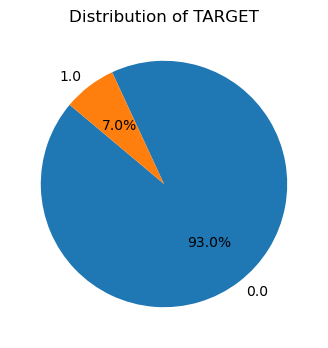

In [29]:
# Create a pie chart for distribution of Target variable
plt.figure(figsize=(4, 4))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of TARGET')
plt.show()

Conclusion: The distribution of calsses is greatly imbalanced. That will be taken into consideration during modeling. 

## <a id="5.2"></a>5.2 Correlations

In [30]:
correlation_matrix = df_V2.corr()
target_correlations = correlation_matrix['TARGET'].drop('TARGET')  

In [31]:
top_positive_correlations = target_correlations.nlargest(5)
top_positive_correlations

BURO_DAYS_CREDIT_MEAN                    0.08
DAYS_BIRTH                               0.07
PREV_NAME_CONTRACT_STATUS_Refused_MEAN   0.07
BURO_DAYS_CREDIT_MIN                     0.07
CLOSED_DAYS_CREDIT_MIN                   0.07
Name: TARGET, dtype: float64

In [32]:
top_negative_correlations = target_correlations.nsmallest(5)
top_negative_correlations

EXT_SOURCE_2                     -0.15
EXT_SOURCE_3                     -0.14
BURO_CREDIT_ACTIVE_Closed_MEAN   -0.07
DAYS_EMPLOYED_PERC               -0.06
CLOSED_MONTHS_BALANCE_SIZE_SUM   -0.05
Name: TARGET, dtype: float64

Conclusion: No significat correlations were identified. 

# <a id="6"></a>6. Modeling

In [33]:
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

## <a id="6.1"></a>6.1 Models: Dummy, Linear, Probabilistic, and Non-linear

Pipileine condists of: 
- Standardscaler
- PCA (explained variance 90%)

In [34]:
target_column = df_V2['TARGET']
df_V2 = df_V2.drop(columns=['TARGET'])

X_train, X_test, y_train, y_test = train_test_split(df_V2, target_column, test_size=0.33, random_state=42)

**custom_scorer**: 
- w_fp = 1 Weight for false positives
- w_fn = 10 Weight for false negatives
- **max_cost_coef** = max(w_fn, w_fp) determines the scaling factor based on the weight of the more important misclassification type (either FP or FN)
- **max_cost** calculates a maximum possible cost by multiplying the total number of samples by the maximum cost coefficient. This represents the worst-case scenario cost (model makes all predictions as FN)
- **score** indicates how well the model performs by comparing the cost of misclassifications to the worst-case scenario cost, with higher scores denoting better performance

In [35]:
# Define the custom scorer
def custom_scorer(estimator, X, y):
    w_fp = 1  # Weight for false positives
    w_fn = 10  # Weight for false negatives

    y_pred = estimator.predict(X)  # Predict labels using the estimator

    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    n_samples = tn + fp + fn + tp  # Total number of samples

    wfp = fp * w_fp
    wfn = fn * w_fn

    max_cost_coef = max(w_fn, w_fp)

    max_cost = n_samples * max_cost_coef

    score = (max_cost - (wfp + wfn)) / max_cost

    return score

In [36]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_reduction', PCA(n_components=0.9, svd_solver='full')),
    ('clf', None),
])

In [39]:
# Define the parameters for grid search
parameters = [
    {
        'clf': [DummyClassifier()],
        'clf__strategy': ['stratified', 'most_frequent', 'uniform'],
    }, {
        'clf': [LogisticRegression(max_iter=650)],
        'clf__C': [0.01, 0.1, 1],
        'clf__class_weight': ['balanced'],
    }, {
        'clf': [GaussianNB()],
        'clf__var_smoothing': [1e-9, 1e-8, 1e-7],
        'clf__priors': [None],
    }, {
        'clf': [LGBMClassifier(verbose=-1)],
        'clf__boosting_type': ['gbdt', 'dart', 'goss'],
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__n_estimators': [100, 200, 300],
        'clf__class_weight': ['balanced'],
    }
]

In [40]:
# Initialize variables to store results
best_models = []
best_params_list = []
best_scores_list = []
training_time_seconds_list = []
custom_scores_test_list = []
roc_auc_test_list = []
accuracyc_test_list = []

model_names = ['DummyClassifier', 'LogisticRegression', 'GaussianNB', 'LGBMClassifier']

In [41]:
def run_grid_search(pipeline, parameters, X_train, y_train, X_test, y_test, model_names):
    """
    Perform grid search with cross-validation for multiple models, log results with MLflow,
    and save the best models.

    Returns:
    - Lists of best models, best parameters, best scores, training times, as well as custom scores,
      ROC AUC scores, and accuracy scores performed on test set.
    """
    
    # Iterate over the models and parameters
    for i, (params, model_name) in enumerate(zip(parameters, model_names)):
         # Start a new MLflow run with the model name
        with mlflow.start_run(run_name=model_name):
            # Perform Grid Search with cross-validation
            grid_search = GridSearchCV(pipeline, params, cv=5, scoring=custom_scorer)

            # Measure the start time of training
            start_time = time.time()
            grid_search.fit(X_train, y_train)
            end_time = time.time()
            
            # Log parameters
            mlflow.log_params(params) 

            # Get the best model and its parameters
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_score = round(grid_search.best_score_, 3)
            training_time_seconds = round(end_time - start_time)
            
            # Log metrics
            mlflow.log_metric("Best custom_score", best_score)
            mlflow.log_metric("TrainingTimeInSeconds", training_time_seconds)

            # Store results
            best_models.append(best_model)
            best_params_list.append(best_params)
            best_scores_list.append(best_score)
            training_time_seconds_list.append(training_time_seconds)

            # Calculate custom score on the test set
            y_pred = best_model.predict(X_test)
            custom_score_test = round(custom_scorer(best_model, X_test, y_test), 3)
            custom_scores_test_list.append(custom_score_test)

            # Evaluate the model on the test set (accuracy, roc_auc)
            y_pred_prob = best_model.predict_proba(X_test)[:, 1]
            roc_auc = round(roc_auc_score(y_test, y_pred_prob), 3)
            roc_auc_test_list.append(roc_auc)
            accuracy = round(accuracy_score(y_test, y_pred), 3)
            accuracyc_test_list.append(accuracy)
            
            # Log metrics
            mlflow.log_metric("Custom Score", custom_score_test)           
            mlflow.log_metric("ROC AUC", roc_auc)
            mlflow.log_metric("Accuracy", accuracy)
            
            # Save the trained model using MLflow
            mlflow.sklearn.log_model(best_model, f"{model_name}_model")
            
            # Save the trained model using joblib
            joblib.dump(best_model, f"{model_name}_model.joblib")

In [42]:
# Perform grid search for the first dataset
run_grid_search(pipeline, parameters, X_train, y_train, X_test, y_test, model_names)

Setuptools is replacing distutils.


In [43]:
target_column_df_V1 = df_V1['TARGET']
df_X_V1 = df_V1.drop(columns=['TARGET'])
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_X_V1, target_column_df_V1, test_size=0.33, random_state=42)

In [44]:
# Define the pipeline for the second dataset
pipeline_V1 = Pipeline([
    ('clf', LGBMClassifier())
])

In [45]:
# Define the parameters for grid search for the second dataset
parameters_V1 = [
    {
        'clf': [LGBMClassifier(verbose=-1)],
        'clf__boosting_type': ['gbdt', 'dart', 'goss'],
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__n_estimators': [100, 200, 300],
        'clf__class_weight': ['balanced'],
    }
]

In [46]:
model_names_2 = ['LGBMClassifier_with_nulls']

In [47]:
# Perform grid search for the second dataset
run_grid_search(pipeline_V1, parameters_V1, X_train1, y_train1, X_test1, y_test1, model_names_2)

In [48]:
best_models

[Pipeline(steps=[('scaler', StandardScaler()),
                 ('dim_reduction', PCA(n_components=0.9, svd_solver='full')),
                 ('clf', DummyClassifier(strategy='most_frequent'))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('dim_reduction', PCA(n_components=0.9, svd_solver='full')),
                 ('clf',
                  LogisticRegression(C=0.1, class_weight='balanced',
                                     max_iter=650))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('dim_reduction', PCA(n_components=0.9, svd_solver='full')),
                 ('clf', GaussianNB())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('dim_reduction', PCA(n_components=0.9, svd_solver='full')),
                 ('clf',
                  LGBMClassifier(boosting_type='dart', class_weight='balanced',
                                 n_estimators=300, verbose=-1))]),
 Pipeline(steps=[('clf',
                  LGBMClassifier(boosting

## <a id="6.3"></a>6.3 Models: Comparison

In [49]:
data = {
    'Best Model': best_models,
    'Best Params': best_params_list,
    'Best Scores': best_scores_list,
    'Training Time (s)': training_time_seconds_list,
    'Custom Scores Test': custom_scores_test_list,
    'ROC AUC Test': roc_auc_test_list,
    'Accuracy Test': accuracyc_test_list
}

# Create a DataFrame
results_df = pd.DataFrame(data)

In [50]:
results_df

Best Model  \
0  (StandardScaler(), PCA(n_components=0.9, svd_s...   
1  (StandardScaler(), PCA(n_components=0.9, svd_s...   
2  (StandardScaler(), PCA(n_components=0.9, svd_s...   
3  (StandardScaler(), PCA(n_components=0.9, svd_s...   
4  (LGBMClassifier(boosting_type='dart', class_we...   

                                         Best Params  Best Scores  \
0  {'clf': DummyClassifier(strategy='most_frequen...         0.93   
1  {'clf': LogisticRegression(C=0.1, class_weight...         0.95   
2  {'clf': GaussianNB(), 'clf__priors': None, 'cl...         0.93   
3  {'clf': LGBMClassifier(boosting_type='dart', c...         0.95   
4  {'clf': LGBMClassifier(boosting_type='dart', c...         0.95   

   Training Time (s)  Custom Scores Test  ROC AUC Test  Accuracy Test  
0                202                0.93          0.50           0.93  
1                504                0.95          0.75           0.69  
2                218                0.94          0.62           0.83  
3               5515                0.95          0.74           0.72  
4               3403                0.95          0.78           0.73

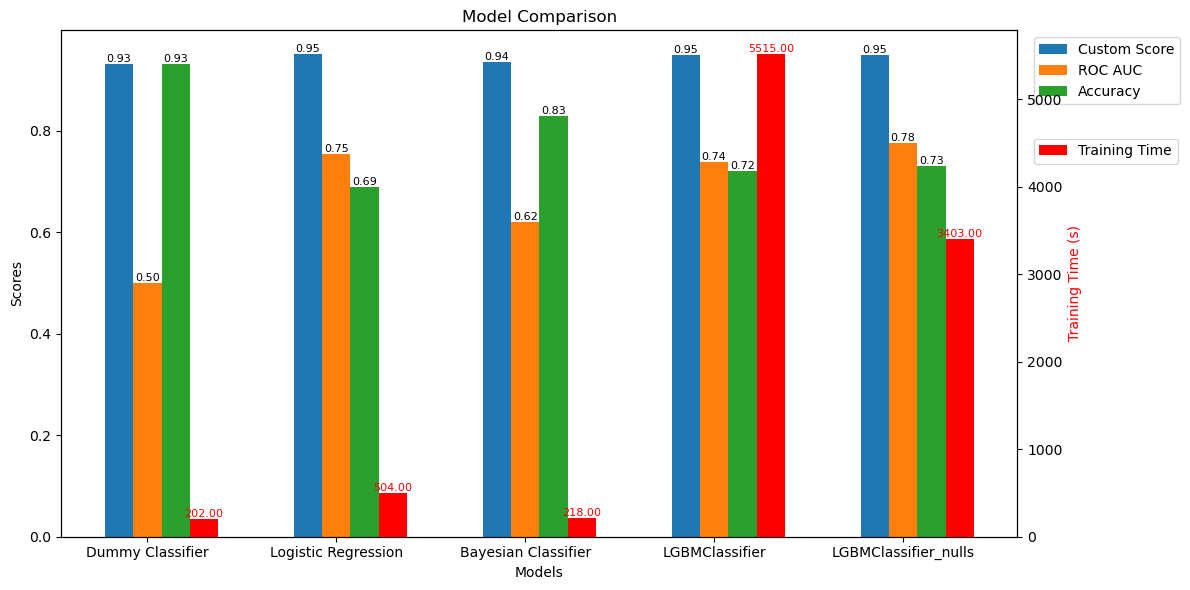

In [51]:
# Test scores for each model
models = ["Dummy Classifier", "Logistic Regression", "Bayesian Classifier", "LGBMClassifier", "LGBMClassifier_nulls"]
custom_scores = custom_scores_test_list
roc_auc_scores = roc_auc_test_list
accuracy_scores = accuracyc_test_list
training_time = training_time_seconds_list

# Create subplots with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Set the width of the bars
bar_width = 0.15

# Position of bars on x-axis
index = np.arange(len(models))

# Create bar plots for custom score, ROC AUC, and accuracy on the first y-axis
bar1 = ax1.bar(index, custom_scores, bar_width, label='Custom Score')
bar2 = ax1.bar(index + bar_width, roc_auc_scores, bar_width, label='ROC AUC')
bar3 = ax1.bar(index + 2 * bar_width, accuracy_scores, bar_width, label='Accuracy')

# Set the labels and title for the first y-axis
ax1.set_xlabel('Models')
ax1.set_ylabel('Scores')
ax1.set_title('Model Comparison')

# Set x-axis tick positions and labels
ax1.set_xticks(index + bar_width)
ax1.set_xticklabels(models)

# Create a twin axes for the second y-axis
ax2 = ax1.twinx()

# Create a bar plot for training time on the second y-axis
bar4 = ax2.bar(index + 3 * bar_width, training_time, bar_width, label='Training Time', color='r')

# Set the label for the second y-axis
ax2.set_ylabel('Training Time (s)', color='r')

# Display the legend for both y-axes outside the graph area
ax1_legend = ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
ax2_legend = ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8))

# Annotate the bars with their respective values (rounded to 2 decimal places)
for i in index:
    ax1.text(i, custom_scores[i], f'{custom_scores[i]:.2f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i + bar_width, roc_auc_scores[i], f'{roc_auc_scores[i]:.2f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i + 2 * bar_width, accuracy_scores[i], f'{accuracy_scores[i]:.2f}', ha='center', va='bottom', fontsize=8)
    ax2.text(i + 3 * bar_width, training_time[i], f'{training_time[i]:.2f}', ha='center', va='bottom', fontsize=8, color='r')

# Show the bar chart
plt.tight_layout()
plt.show()


In [52]:
def plot_evaluation_metrics(model, X_test, y_test, model_name):
    """
    Plot confusion matrix and ROC/AUC curve for a binary classification model.
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0].set_title(f'Confusion Matrix - {model_name}')
    plt.colorbar(im, ax=axes[0])
    
    classes = ["0", "1"]
    tick_marks = range(len(classes))
    axes[0].set_xticks(tick_marks)
    axes[0].set_xticklabels(classes)
    axes[0].set_yticks(tick_marks)
    axes[0].set_yticklabels(classes)
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            axes[0].text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    
    axes[0].set_xlabel('Predicted label')
    axes[0].set_ylabel('True label')
    
    # Calculate ROC curve and AUC
    y_prob = model.predict_proba(X_test)[:, 1]  # predict_proba
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)  # Calculate ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve - {model_name}')
    axes[1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()


**Confusion matrix explanation** : 
- True Positives (TP) indicate correct predictions of high-risk applicants with payment difficulties (TARGET=1).
- True Negatives (TN) show correct predictions of low-risk applicants without payment difficulties (TARGET=0).
- False Positives (FP) represent incorrect predictions of high-risk applicants who are actually low-risk, potentially causing unnecessary rejections (TARGET=1).
- False Negatives (FN) indicate incorrect predictions of low-risk applicants who are actually high-risk, possibly leading to loans granted to applicants who later default (TARGET=0).

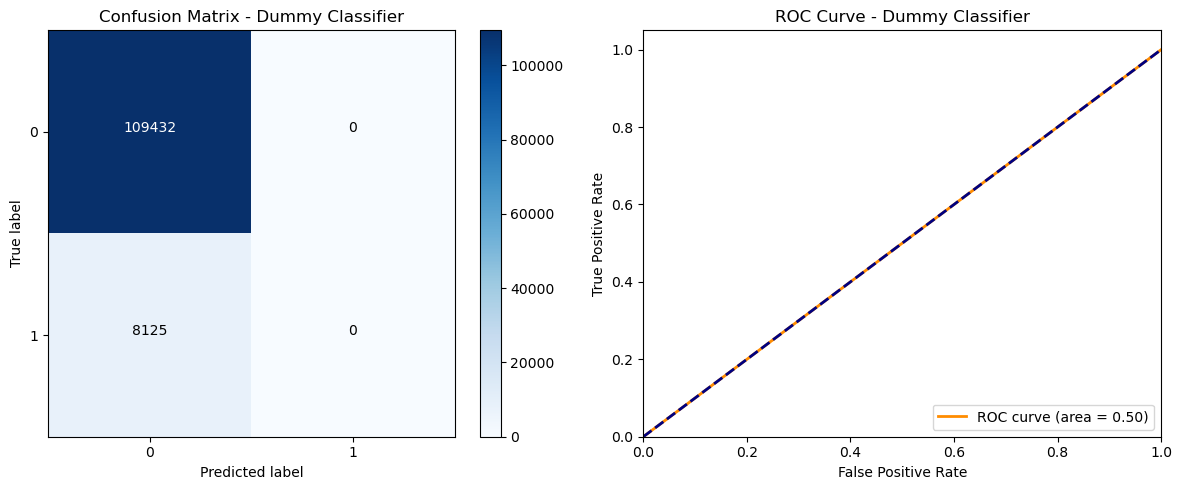

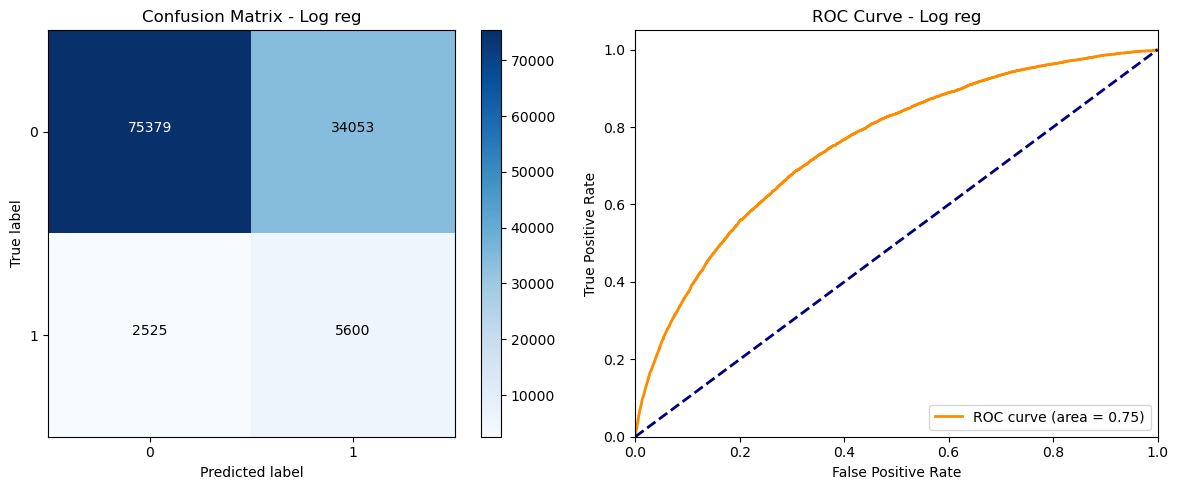

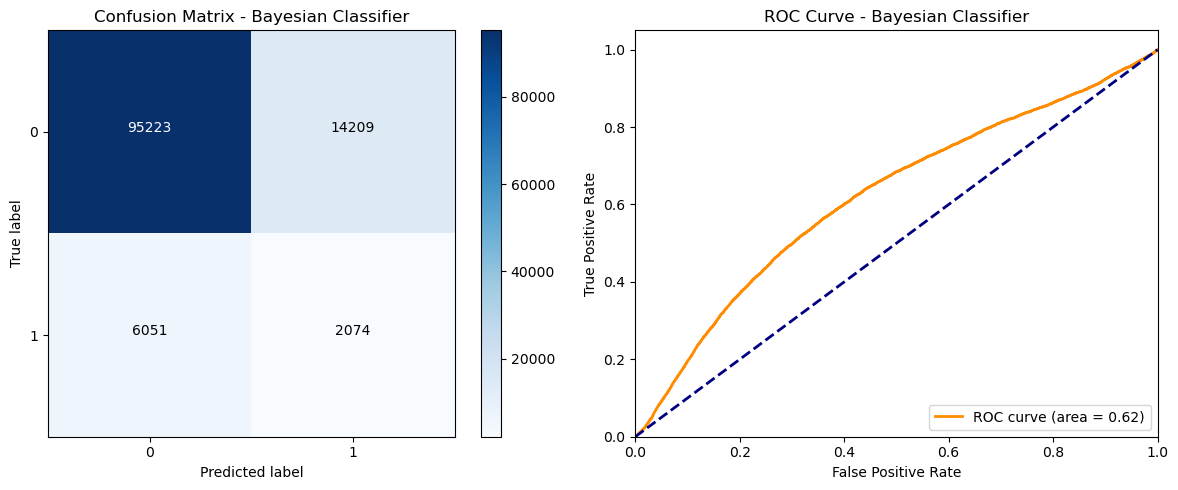

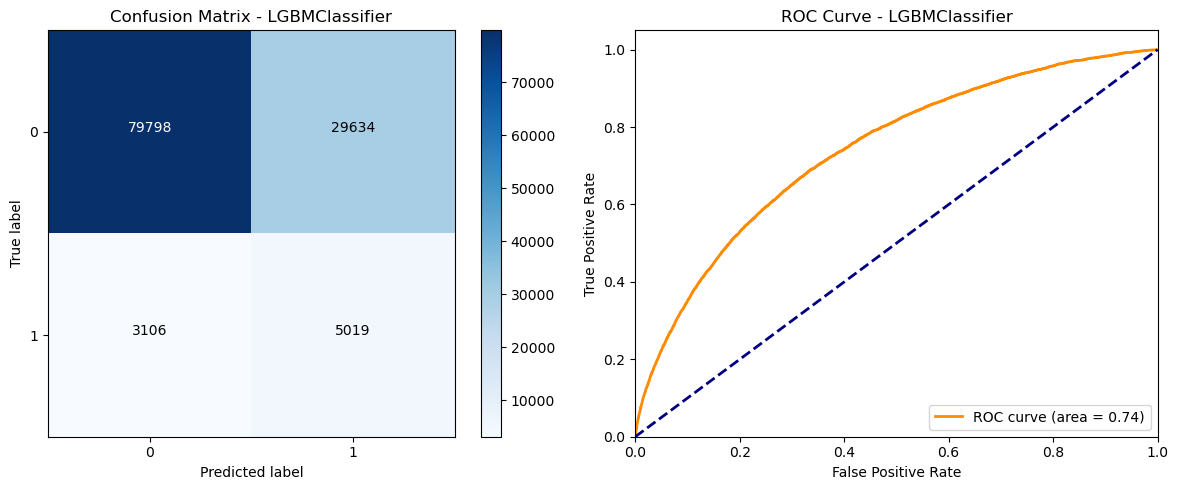

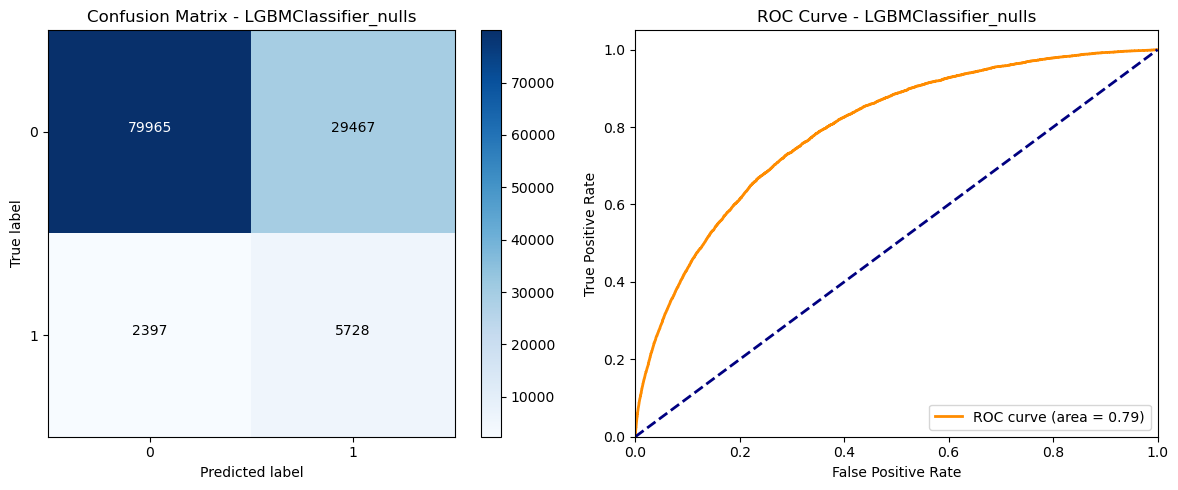

In [53]:
plot_evaluation_metrics(best_models[0], X_test, y_test, "Dummy Classifier")
plot_evaluation_metrics(best_models[1], X_test, y_test, "Log reg")
plot_evaluation_metrics(best_models[2], X_test, y_test, "Bayesian Classifier")
plot_evaluation_metrics(best_models[3], X_test, y_test, "LGBMClassifier")
plot_evaluation_metrics(best_models[4], X_test, y_test, "LGBMClassifier_nulls")

### LGBMClassifier_with_nulls model performance 

In [77]:
LGBMClassifier_with_nulls = best_models[4]

In [80]:
# Calculate predicted probabilities from the model
predicted_probabilities = LGBMClassifier_with_nulls.predict_proba(X_test1)[:, 1]
y_pred = (predicted_probabilities >= 0.5).astype(int)

# Define the number of bins
num_bins = 10

# Divide probability values into bins
hist, bin_edges = np.histogram(predicted_probabilities, bins=num_bins)

# Initialize a list to store custom scores for each bin
custom_scores = []

for i in range(num_bins):
    # Define bin boundaries
    lower_boundary = bin_edges[i]
    upper_boundary = bin_edges[i + 1]

    # Select predictions falling within the bin
    in_bin = (predicted_probabilities >= lower_boundary) & (predicted_probabilities < upper_boundary)

    # Ensure y_test1 and y_pred are 2D arrays
    y_test_bin = y_test1[in_bin].to_numpy().reshape(-1, 1)
    y_pred_bin = y_pred[in_bin].reshape(-1, 1)

    # Pass input features X_test1 to the custom scorer function
    custom_score = custom_scorer(LGBMClassifier_with_nulls, X_test1[in_bin], y_test_bin)

    # Append the custom score to the list
    custom_scores.append(custom_score)

# Print or visualize the custom scores for each bin
for i in range(num_bins):
    print(f'Bin {i}: Custom Score={custom_scores[i]:.3f}')

Bin 0: Custom Score=0.990
Bin 1: Custom Score=0.985
Bin 2: Custom Score=0.974
Bin 3: Custom Score=0.954
Bin 4: Custom Score=0.931
Bin 5: Custom Score=0.910
Bin 6: Custom Score=0.914
Bin 7: Custom Score=0.919
Bin 8: Custom Score=0.931
Bin 9: Custom Score=0.948


In [81]:
print(bin_edges)

[0.02154805 0.11269583 0.20384361 0.29499139 0.38613917 0.47728695
 0.56843473 0.65958251 0.75073029 0.84187807 0.93302585]


## <a id="6.4"></a>6.4 Custom score: Threshold optimisation

example code: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/ 

In [78]:
# predict probabilities
yhat = LGBMClassifier_with_nulls.predict_proba(X_test1)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.1)

scores = []

for t in thresholds:
    # Convert probabilities to labels based on the threshold
    y_pred = (probs >= t).astype(int)
    
    # Calculate custom score
    w_fp = 1  # Weight for false positives
    w_fn = 10  # Weight for false negatives
    tn, fp, fn, tp = confusion_matrix(y_test1, y_pred).ravel()
    n_samples = tn + fp + fn + tp
    wfp = fp * w_fp
    wfn = fn * w_fn
    max_cost_coef = max(w_fn, w_fp)
    max_cost = n_samples * max_cost_coef
    score = (max_cost - (wfp + wfn)) / max_cost

    scores.append(score)

# Find the best threshold
best_threshold = thresholds[np.argmax(scores)]
best_score = np.max(scores)

print(f'Threshold={best_threshold}, custom_score={best_score:.3f}')

Threshold=0.5, custom_score=0.949


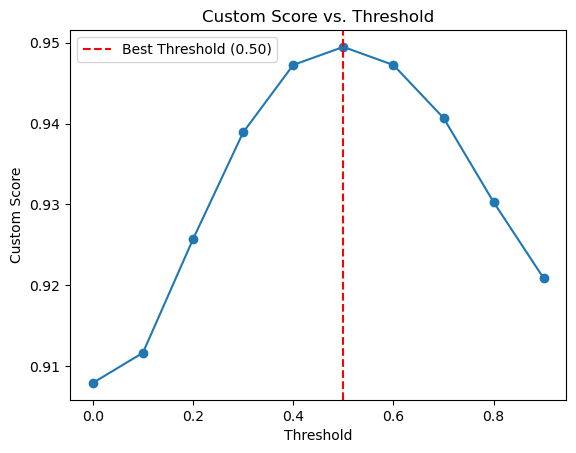

In [79]:
# Plot the custom score as a function of threshold
plt.plot(thresholds, scores, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('Custom Score')
plt.title('Custom Score vs. Threshold')

# Mark the best result on the graph with line
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')

plt.legend()
plt.show()

### Save pipeline

In [60]:
from mlflow.models.signature import infer_signature
import mlflow.sklearn
signature = infer_signature(X_train1, y_train1)
mlflow.sklearn.save_model(pipeline_V1, 'mlflow_model', signature=signature)
mlflow.end_run()

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


## <a id="6.5"></a>6.5 Feature importance 
## <a id="6.5.1"></a>6.5.1 Global feature importance

Global importance assesses the overall significance of each feature across the entire dataset, helping to identify which features are generally important for a machine learning model's predictions.

Example code: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html

In [82]:
lgbm_model = LGBMClassifier_with_nulls.steps[-1][1]
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test1)

C:\Users\Madara\anaconda3\Lib\site-packages\shap\explainers\_tree.py:382: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



In [96]:
# Save the subset of SHAP values for dashboard
first_1000_rows = X_test1.iloc[:1000, :]
shap_values_1000 = explainer.shap_values(first_1000_rows)
joblib.dump(shap_values_1000, 'shap_values.pkl')

C:\Users\Madara\anaconda3\Lib\site-packages\shap\explainers\_tree.py:382: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



['shap_values.pkl']

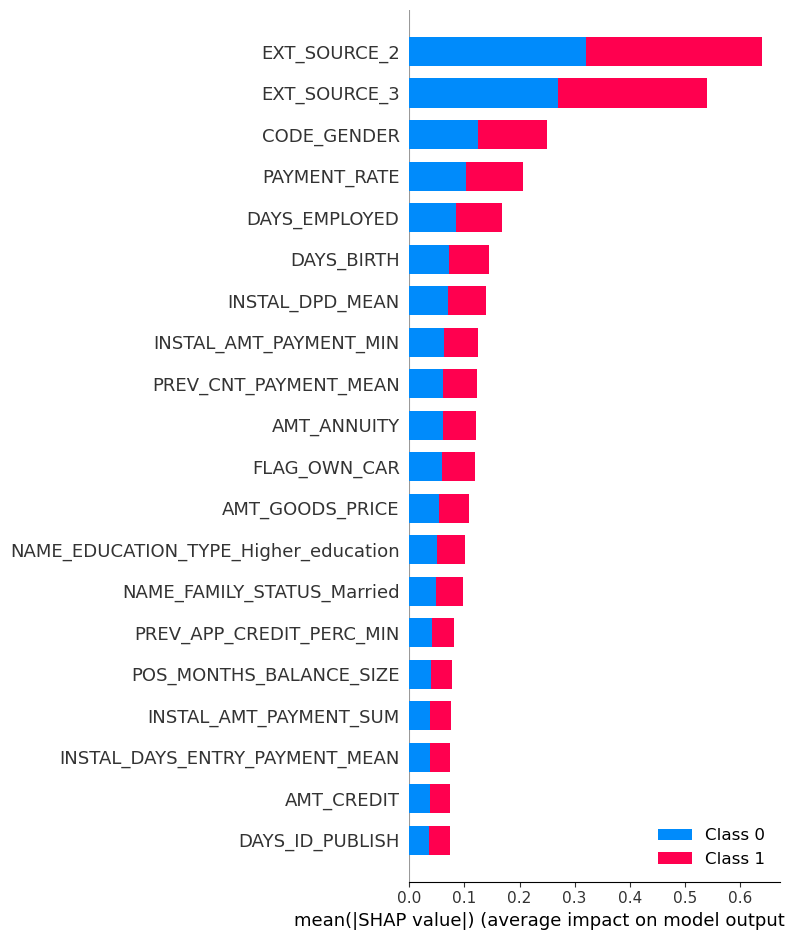

In [84]:
shap.summary_plot(shap_values, X_test1, max_display=20)

In [85]:
# Display top 50 most important features
shaps = np.abs(shap_values[1]).sum(0)
shap_importance = np.argsort(shaps)[::-1]
top_n_importance = 50
important_cols = list(shap_importance.flatten()[:top_n_importance])

In [86]:
column_names = X_test1.columns[important_cols]
column_names

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'CODE_GENDER', 'PAYMENT_RATE',
       'DAYS_EMPLOYED', 'DAYS_BIRTH', 'INSTAL_DPD_MEAN',
       'INSTAL_AMT_PAYMENT_MIN', 'PREV_CNT_PAYMENT_MEAN', 'AMT_ANNUITY',
       'FLAG_OWN_CAR', 'AMT_GOODS_PRICE',
       'NAME_EDUCATION_TYPE_Higher_education', 'NAME_FAMILY_STATUS_Married',
       'PREV_APP_CREDIT_PERC_MIN', 'POS_MONTHS_BALANCE_SIZE',
       'INSTAL_AMT_PAYMENT_SUM', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'AMT_CREDIT', 'DAYS_ID_PUBLISH', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
       'PREV_NAME_YIELD_GROUP_low_action_MEAN', 'FLAG_DOCUMENT_3',
       'NAME_EDUCATION_TYPE_Secondary___secondary_special',
       'ACTIVE_DAYS_CREDIT_MAX', 'NAME_CONTRACT_TYPE_Cash_loans',
       'APPROVED_CNT_PAYMENT_MEAN', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
       'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'INSTAL_PAYMENT_DIFF_MEAN',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED_PERC',
       'BURO_CREDIT_ACTIVE_Closed_MEAN', 'PREV_NAME_YIELD_GROUP_high_MEAN',
      

## <a id="6.5.2"></a>6.5.2 Local feature importance

In [92]:
# Local feature importance for client where index = 5
shap.initjs()
shap.force_plot(explainer.expected_value[1], 
                shap_values[1][0,:], 
                df_X_V1.iloc[0,:])

## <a id="7"></a>7. Data drift by Evidently

In [67]:
# Exclude the 'TARGET' column from both datasets
df_V1_e = df_V1.drop(columns=['TARGET'])
df_V1_T_e = df_V1_T.drop(columns=['TARGET'])

In [68]:
# Extract only the top features from the reference and current datasets
df_V1_top = df_V1_e[column_names]
df_V1_T_top = df_V1_T_e[column_names]

In [69]:
# Start the timer
start_time = time.time()

# Create a Data Drift report using DataDriftPreset
data_drift_report = Report(metrics=[DataDriftPreset()])

# Calculate data drift by comparing reference and current data for the top features
data_drift_report.run(reference_data=df_V1_top, current_data=df_V1_T_top)

# Calculate the time taken
end_time = time.time()
elapsed_time = end_time - start_time

# Print progress and time taken
print("Data drift report completed in {:.2f} seconds".format(elapsed_time))

data_drift_report.save_html("data_drift_report.html")
webbrowser.open("data_drift_report.html")

Data drift report completed in 169.31 seconds


True

Source code: https://github.com/evidentlyai/evidently/blob/main/examples/integrations/mlflow_logging/mlflow_integration.ipynb

In [88]:
from evidently.pipeline.column_mapping import ColumnMapping
data_columns = ColumnMapping()
data_columns.numerical_features = column_names

In [89]:
def eval_drift(reference, production, column_mapping, threshold=0.1):
    """
    Returns a list with pairs (feature_name, drift_score)
    Drift Score depends on the selected statistical test or distance and the threshold
    """    
    data_drift_report = Report(metrics=[DataDriftPreset()])
    data_drift_report.run(reference_data=reference, current_data=production)
    report = data_drift_report.as_dict()

    drifting_columns = []

    for feature in column_mapping.numerical_features:
        drift_score = report["metrics"][1]["result"]["drift_by_columns"][feature]["drift_score"]
        if drift_score > threshold:
            drifting_columns.append((feature, drift_score))
    
    return drifting_columns

In [90]:
from datetime import datetime

mlflow.set_experiment('Dataset Drift Analysis with Evidently')

run_name = f"DataDrift_{datetime.now().strftime('%Y%m%d')}"

with mlflow.start_run(run_name=run_name) as run: 
    # Log parameters
    mlflow.log_param("reference_dataset", "df_V1_top")
    mlflow.log_param("current_dataset", "df_V1_T_top")

    # Log metrics
    threshold = 0.1
    drifting_columns = eval_drift(df_V1_top, df_V1_T_top, column_mapping=data_columns, threshold=threshold)
    
    count_exceeded_threshold = len(drifting_columns)
    mlflow.log_metric("num_columns_exceeded_threshold", count_exceeded_threshold)
    
    total_columns = len(data_columns.numerical_features)
    share_drifted_columns = count_exceeded_threshold / total_columns
    mlflow.log_metric("share_drifted_columns", share_drifted_columns)

2023/11/30 19:43:25 INFO mlflow.tracking.fluent: Experiment with name 'Dataset Drift Analysis with Evidently' does not exist. Creating a new experiment.
